In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import itertools
import warnings

In [2]:
# Suppress warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the dataset
data = pd.read_csv('pre_data.csv', parse_dates=['Date'], index_col='Date')

In [4]:
print(data.head())

            Organization_ID  Energy_Consumption_kWh  Temperature_C  \
Date                                                                 
2021-01-01                7                 1173.57           36.3   
2021-01-02                4                  812.70           17.4   
2021-01-03                8                  824.89           29.4   
2021-01-04                5                 1040.92           13.1   
2021-01-05                7                  879.47           17.0   

            Humidity_%  Wind_Speed_kmh  Precipitation_mm Weather_Condition  
Date                                                                        
2021-01-01          78            17.7              10.0            Cloudy  
2021-01-02          21             6.7               2.0            Cloudy  
2021-01-03          95             8.1               0.0             Snowy  
2021-01-04          29            11.4               0.0             Sunny  
2021-01-05          63             3.5         

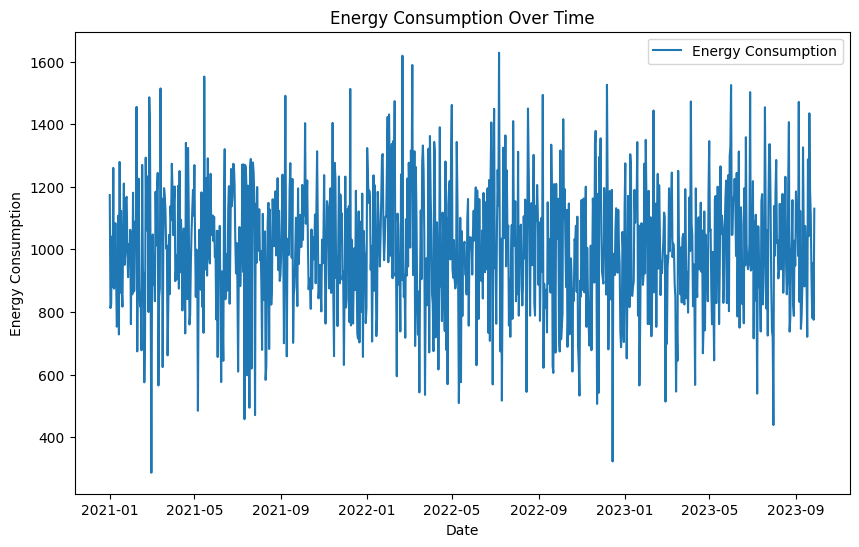

In [5]:
# Visualize the data
plt.figure(figsize=(10,6))
plt.plot(data['Energy_Consumption_kWh'], label='Energy Consumption')
plt.title('Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

In [6]:
# Train-test split (80% for training, 20% for testing)
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

In [7]:
# Function to evaluate SARIMA model with given parameters
def evaluate_sarima(train, test, order, seasonal_order):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
    return mean_absolute_error(test, predictions), mean_squared_error(test, predictions)

In [8]:
# Define the p, d, q parameters to take values between 0 and 2
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))


In [9]:
# Define the seasonal parameters to take values
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in itertools.product(p, d, q)]

In [10]:
best_mae = float("inf")
best_params = None

In [11]:
# Grid search for the best parameters
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            mae, mse = evaluate_sarima(train_data['Energy_Consumption_kWh'], test_data['Energy_Consumption_kWh'], param, seasonal_param)
            if mae < best_mae:
                best_mae = mae
                best_params = (param, seasonal_param)
        except Exception as e:
            continue

In [12]:
print(f'Best MAE: {best_mae} with parameters: {best_params}')

Best MAE: 153.0177096600915 with parameters: ((0, 1, 1), (2, 0, 2, 12))


In [13]:
# Create and fit the best SARIMA model
best_order, best_seasonal_order = best_params
final_model = SARIMAX(train_data['Energy_Consumption_kWh'], order=best_order, seasonal_order=best_seasonal_order)
final_sarima_model = final_model.fit(disp=False)

In [14]:
# Make predictions on the test data using the best model
final_predictions = final_sarima_model.predict(start=len(train_data), end=len(data)-1, dynamic=False)

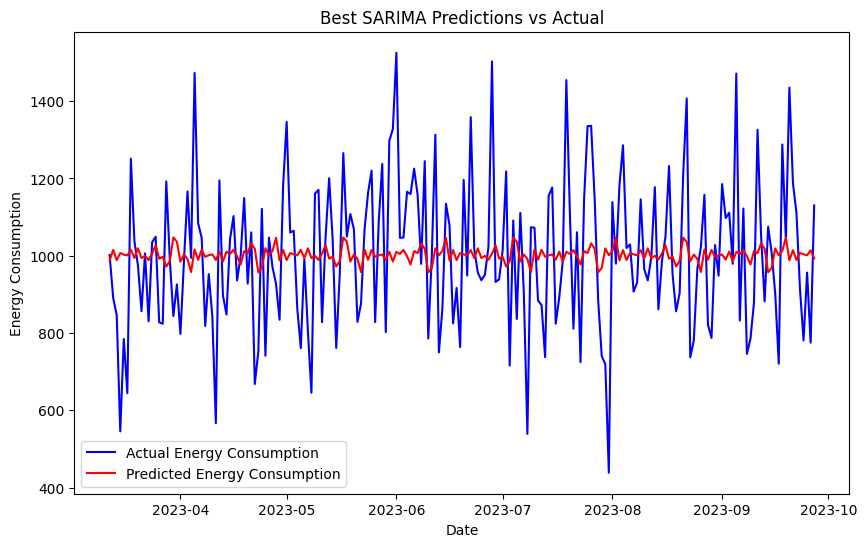

In [15]:
# Plot predictions vs actual data
plt.figure(figsize=(10,6))
plt.plot(test_data.index, test_data['Energy_Consumption_kWh'], label='Actual Energy Consumption', color='blue')
plt.plot(test_data.index, final_predictions, label='Predicted Energy Consumption', color='red')
plt.title('Best SARIMA Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

In [16]:
# Calculate accuracy using RMSE and R-squared
final_rmse = mean_squared_error(test_data['Energy_Consumption_kWh'], final_predictions, squared=False)
final_r2 = r2_score(test_data['Energy_Consumption_kWh'], final_predictions)

In [17]:
# Display accuracy metrics
print(f'Final RMSE: {final_rmse}')
print(f'Final R-squared: {final_r2}')

Final RMSE: 191.64135913515128
Final R-squared: 0.025055286446945324


In [18]:
# Calculate the accuracy metrics
final_mae = mean_absolute_error(test_data['Energy_Consumption_kWh'], final_predictions)
final_mape = np.mean(np.abs((test_data['Energy_Consumption_kWh'] - final_predictions) / test_data['Energy_Consumption_kWh'])) * 100
final_accuracy = 100 - final_mape

In [19]:
# Print the results
print(f"Mean Absolute Error (MAE): {final_mae}")
print(f"Root Mean Squared Error (RMSE): {final_rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {final_mape}%")
print(f"Accuracy: {final_accuracy}%")

Mean Absolute Error (MAE): 153.0177096600915
Root Mean Squared Error (RMSE): 191.64135913515128
Mean Absolute Percentage Error (MAPE): 16.419125738099495%
Accuracy: 83.5808742619005%
